In [1]:
# Carson Batchelor

In [2]:
#! hdfs dfsadmin -fs hdfs://nn:9000 -report
! hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/
#! hdfs dfs -ls hdfs://nn:9000/

In [3]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/31 19:33:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#q1
banks_df = spark.read.csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv", header=True, inferSchema=True)
first_banks_count = banks_df.rdd.filter(lambda row: "first" in row['respondent_name'].lower()).count()
first_banks_count

525

In [5]:
#q2
from pyspark.sql.functions import lower
first_banks_count = banks_df.filter(lower(banks_df["respondent_name"]).like("%first%")).count()
first_banks_count

525

In [6]:
#q3
banks_df.write.saveAsTable("banks", mode="overwrite")
result_df = spark.sql("""
SELECT COUNT(*) AS count 
FROM banks 
WHERE LOWER(respondent_name) LIKE '%first%'
""").toPandas()
result_df["count"][0]

23/10/31 19:34:16 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/10/31 19:34:16 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/10/31 19:34:21 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/10/31 19:34:21 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.22.0.2
23/10/31 19:34:22 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/10/31 19:34:27 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/10/31 19:34:27 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/10/31 19:34:27 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/10/31 19:34:27 W

525

In [7]:
loans_df = spark.read.csv("hdfs://nn:9000/hdma-wi-2021.csv", header=True, inferSchema=True)
loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", format="parquet", mode="overwrite")

23/10/31 19:34:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
csv_files = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
             "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]
for file_name in csv_files:
    view_df = spark.read.csv(f"hdfs://nn:9000/{file_name}.csv", header=True, inferSchema=True)
    view_df.createOrReplaceTempView(file_name)

In [9]:
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



In [10]:
#q4
table_dict = {}
for row in spark.sql("SHOW TABLES").collect():
    table_dict[row["tableName"]] = row["isTemporary"]

table_dict

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [11]:
#q5
loan_count = spark.sql("""
    SELECT COUNT(*) AS loan_count
    FROM banks
    INNER JOIN loans ON banks.lei_2020 = loans.lei
    WHERE banks.respondent_name = 'University of Wisconsin Credit Union'
""").toPandas()
loan_count["loan_count"][0]

19739

In [12]:
#q6
spark.sql("""
    SELECT COUNT(*) AS loan_count
    FROM banks
    INNER JOIN loans ON banks.lei_2020 = loans.lei
    WHERE banks.respondent_name = 'University of Wisconsin Credit Union'
""").explain("formatted")

# 1. The banks table is sent to every executor via a BroadcastExchange operation
# I know this because in the (4) BroadcastExchange step in the plan, it is broadcasting "lei_200" column from the banks table to the worker nodes
# 2. Yes the plan involves two HashAggregate operations.
# The first operation is after the join with the aggregate function used being partial_count(1) to calulation a partial count of rows
# The second operation is after the first one and uses the function count(1) to calculate the final count of loan apps recieved by a bank

== Physical Plan ==
AdaptiveSparkPlan (12)
+- HashAggregate (11)
   +- Exchange (10)
      +- HashAggregate (9)
         +- Project (8)
            +- BroadcastHashJoin Inner BuildLeft (7)
               :- BroadcastExchange (4)
               :  +- Project (3)
               :     +- Filter (2)
               :        +- Scan parquet spark_catalog.default.banks (1)
               +- Filter (6)
                  +- Scan parquet spark_catalog.default.loans (5)


(1) Scan parquet spark_catalog.default.banks
Output [2]: [respondent_name#66, lei_2020#70]
Batched: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,University of Wisconsin Credit Union), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,lei_2020:string>

(2) Filter
Input [2]: [respondent_name#66, lei_2020#70]
Condition : ((isnotnull(respondent_name#66) AND (respondent_name#66 = University of Wisconsin Credit Union)) AND i

In [13]:
wells_fargo = spark.sql("""
    SELECT *
    FROM banks
    INNER JOIN loans ON banks.lei_2020 = loans.lei
    WHERE banks.respondent_name LIKE '%Wells Fargo%'
""").createOrReplaceTempView("wells_fargo")

counties_names = spark.sql("""
    SELECT DISTINCT COUNTY, NAME
    FROM counties
    WHERE STATE == 55 
""").toPandas()

In [14]:
#q7
avg_rates = spark.sql("""
    SELECT county_code, AVG(interest_rate) AS avg_interest_rate
    FROM wells_fargo
    GROUP BY county_code
    ORDER BY COUNT(*) DESC
    LIMIT 10
""").toPandas()
avg_rates_dict = dict(zip(avg_rates["county_code"], avg_rates["avg_interest_rate"]))

named_avg_rates = {}
for key, value in avg_rates_dict.items():
    county_name = counties_names.loc[counties_names["COUNTY"] == int(key[-3:]), "NAME"].values[0]
    named_avg_rates[county_name] = value
named_avg_rates

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

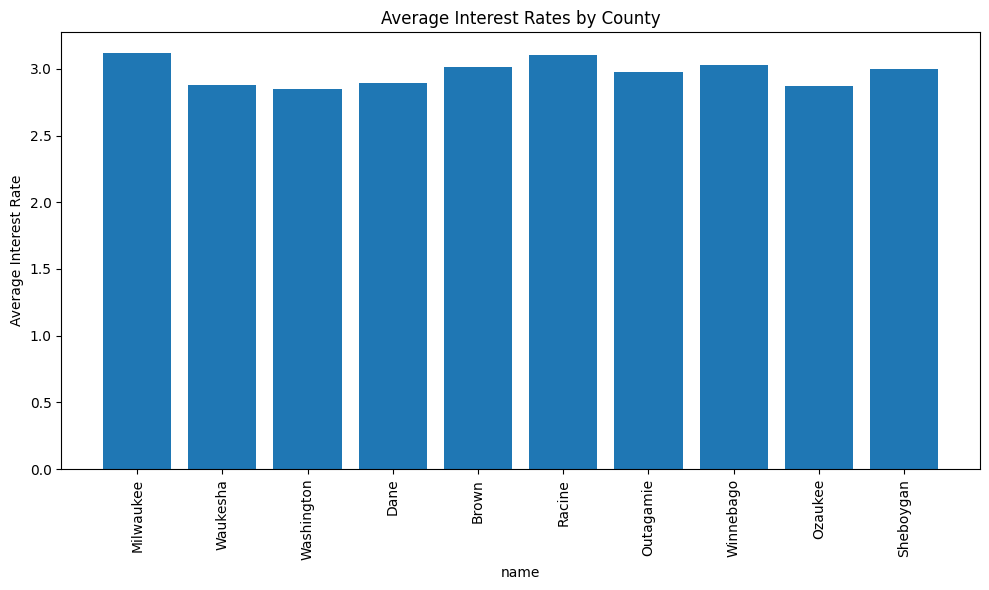

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(named_avg_rates.keys(), named_avg_rates.values())
plt.xlabel('name')
plt.ylabel('Average Interest Rate')
plt.title('Average Interest Rates by County')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
#q8
# Group by county_code
spark.sql("""
SELECT county_code, AVG(interest_rate) 
FROM loans 
GROUP BY county_code
""").explain()

# Group by lei column
spark.sql("""
SELECT lei, AVG(interest_rate) 
FROM loans 
GROUP BY lei
""").explain()

# There is no need for network I/O  in the first query because all data needed for partial mean is qlready in each bucket.
# Also because the data for each county_code is in the same node.

# In the second query where we group by lei, network I/O might be necessary due to hashpartitioning
# The data is shuffled between nodes based on 'lei' values for the partial mean. so Network I/O occurs because the data 
# for each lei value may be in different nodes so the data needs to be transferred between nodes to calculate the partial mean.

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#1021], functions=[avg(cast(interest_rate#1040 as double))])
   +- HashAggregate(keys=[county_code#1021], functions=[partial_avg(cast(interest_rate#1040 as double))])
      +- FileScan parquet spark_catalog.default.loans[county_code#1021,interest_rate#1040] Batched: true, Bucketed: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,interest_rate:string>, SelectedBucketsCount: 8 out of 8


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#1018], functions=[avg(cast(interest_rate#1040 as double))])
   +- Exchange hashpartitioning(lei#1018, 200), ENSURE_REQUIREMENTS, [plan_id=827]
      +- HashAggregate(keys=[lei#1018], functions=[partial_avg(cast(interest_rate#1040 as double))])
         +- FileScan parquet spark_catalog.

In [17]:
df = spark.sql("""
    SELECT 
        CAST(loan_amount AS DOUBLE),
        CAST(income AS DOUBLE),
        CAST(interest_rate AS DOUBLE),
        CASE WHEN action_taken == 1
            THEN 1.0 ELSE 0.0 END AS approval
    FROM loans
""")
df = df.fillna(0.0)

# deterministic split
train, test = df.randomSplit([0.8, 0.2], seed=41) 
train.cache()

DataFrame[loan_amount: double, income: double, interest_rate: double, approval: decimal(2,1)]

In [18]:
#q9
approved = train.filter(train.approval == 1).count()
approved

242868

In [19]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

vector_assembler = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features")

train_data = vector_assembler.transform(train)
test_data = vector_assembler.transform(test)

classifier = DecisionTreeClassifier(maxDepth=5, labelCol="approval", featuresCol="features")
model = classifier.fit(train_data)

predictions = model.transform(test_data)

In [20]:
#q10
total_count = predictions.count()
correct_count = predictions.filter(predictions.prediction == predictions.approval).count()
accuracy = correct_count / total_count
accuracy

0.8940103963757389